In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [ ]:
!pip install -U -q PyDrive2
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive2 client here .
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1L8x0-UoC5rKojAF5Sl2c24g3RkKAw59C'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device1.csv')   # Device1

id = '10Ha1X0FUjVwWcGaVFKcavJmiMFJBrzlc'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device2.csv')   # Device2

id = '1hqOpot1QnZNBn-AAYqmPWYberH4_Eqyy'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device3.csv')   # Device3

id = '150-W1t_378CZmQg-7fdfsUwl6KmkVzp4'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device4.csv')   # Device4

id = '1k4z7mn6pKmwyqf9tJ-zIMLEKyCFR9ohF'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device5.csv')   # Device5

id = '1Ns8_oVBIyo-WbVnlPQZnT6Krobwdl-Jz'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device6.csv')   # Device6

id = '1FYXJ6eIJC9fG79KinSboF5VPZ_GeH-lT'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device7.csv')   # Device7

id = '1Vw8ZlWvYOlvgEREhUSju7hcB9ntQcE34'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device8.csv')   # Device8

id = '1QdOZR6MyccnLtbZnOy0eCpsOqi9zoczM'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Device9.csv')   # Device9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 695.5 kB/s eta 0:00:00


In [ ]:
# load data
d1 = pd.read_csv('/content/Device1.csv', nrows=500000)
d2 = pd.read_csv('/content/Device2.csv', nrows=500000)
d3 = pd.read_csv('/content/Device3.csv', nrows=500000)
d4 = pd.read_csv('/content/Device4.csv', nrows=500000)
d5 = pd.read_csv('/content/Device5.csv', nrows=500000)
d6 = pd.read_csv('/content/Device6.csv', nrows=500000)
d7 = pd.read_csv('/content/Device7.csv', nrows=500000)
d8 = pd.read_csv('/content/Device8.csv', nrows=500000)
d9 = pd.read_csv('/content/Device9.csv', nrows=500000)

d1.shape, d2.shape, d3.shape, d4.shape,d5.shape, d6.shape, d7.shape, d8.shape, d9.shape



((500000, 117),
 (500000, 117),
 (355500, 117),
 (500000, 117),
 (500000, 117),
 (500000, 117),
 (375222, 117),
 (500000, 117),
 (414622, 117))

In [ ]:
def pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign']
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1

    # spliting benign data evenly to three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()    # with label 116

    train_label = benign_train['type']

    benign_train = benign_train.drop('type',axis=1)
    benign_tr = benign_tr.drop('type',axis=1)

    # Creating  Mix data
    abnormal_sample = abnormal.sample(frac = 1)              # selection 10% abnormal data
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]) # concatenating
    mix_temp = shuffle(mix_temp, random_state=1)

    mix = mix_temp.copy()
    mix_data = mix_temp.drop('type',axis=1)
    mix_label = mix['type']

    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train)
    benign_tr = scaler.transform(benign_tr)
    mix_data = scaler.transform(mix_data)

    # keeping  benign_train as original form here --> for later use
    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)    # 115  all benign --> for calculate threshold
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)      # 115  benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))
    return benign_train, benign_tr, mix_data, mix_label

In [ ]:
def other_pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign']
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1

    # split benign data to two parts
    benign_tr, benign_test = train_test_split(benign, test_size = 0.2, random_state = 5703)
    benign_tr = benign_tr.drop('type',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)           # 116  use all abnoraml, but can change to use part
    mix_temp = pd.concat([benign_test, abnormal_sample])  # 116
    mix_temp = shuffle(mix_temp, random_state=1)          # for test model

    mix = mix_temp.copy()                   # mix data with label # 116
    mix_data = mix_temp.drop('type',axis=1) # no label # 115
    mix_label = mix['type']

    # Standardisation
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)
    mix_data = scaler.transform(mix_data)

    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)  # 115  all benign --> for calculate threshold
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)    # 115  data -> benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))                         # 0/1  label -> benign + abnormal  --> for evaluation

    return benign_tr, mix_data, mix_label

In [ ]:
# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)
benign_train_2, benign_tr_2, mix_data_2, mix_label_2 = pre_processing(d2)
benign_train_3, benign_tr_3, mix_data_3, mix_label_3 = pre_processing(d3)
benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)
benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)
benign_train_6, benign_tr_6, mix_data_6, mix_label_6 = pre_processing(d6)
benign_train_7, benign_tr_7, mix_data_7, mix_label_7 = pre_processing(d7)
benign_train_8, benign_tr_8, mix_data_8, mix_label_8 = pre_processing(d8)
benign_train_9, benign_tr_9, mix_data_9, mix_label_9 = pre_processing(d9)


<ipython-input-4-2f308caa7172>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  benign = benign.drop('type',1)
<ipython-input-4-2f308caa7172>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  abnormal = abnormal.drop('type',1)
<ipython-input-4-2f308caa7172>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  benign = benign.drop('type',1)
<ipython-input-4-2f308caa7172>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  abnormal = abnormal.drop('type',1)
<ipython-input-4-2f308caa7172>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  benign = benign.drop('type',

In [ ]:
num_clients = 9      # Number of clients
num_selected = 3     # Typically, num_selected is around 30–40% of the num_clients.
batch_size = 128
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 3#100      # Total number of communication rounds for the global model to train.
epochs = 5          # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.


In [ ]:

# For retraining mechanism
# pick baseline_data for each device
def baseline_data(size = baseline_num, batch_size = batch_size): # baseline_num
    rng = np.random.default_rng()
    x_1 = rng.choice(benign_train_1, size=size, replace = True, shuffle = True, axis=0)
    x_2 = rng.choice(benign_train_2, size=size, replace = True, shuffle = True, axis=0)
    x_3 = rng.choice(benign_train_3, size=size, replace = True, shuffle = True, axis=0)
    x_4 = rng.choice(benign_train_4, size=size, replace = True, shuffle = True, axis=0)
    x_5 = rng.choice(benign_train_5, size=size, replace = True, shuffle = True, axis=0)
    x_6 = rng.choice(benign_train_6, size=size, replace = True, shuffle = True, axis=0)
    x_7 = rng.choice(benign_train_7, size=size, replace = True, shuffle = True, axis=0)
    x_8 = rng.choice(benign_train_8, size=size, replace = True, shuffle = True, axis=0)
    x_9 = rng.choice(benign_train_9, size=size, replace = True, shuffle = True, axis=0)


    loader_1 = torch.utils.data.DataLoader(x_1, batch_size=batch_size)
    loader_2 = torch.utils.data.DataLoader(x_2, batch_size=batch_size)
    loader_3 = torch.utils.data.DataLoader(x_3, batch_size=batch_size)
    loader_4 = torch.utils.data.DataLoader(x_4, batch_size=batch_size)
    loader_5 = torch.utils.data.DataLoader(x_5, batch_size=batch_size)
    loader_6 = torch.utils.data.DataLoader(x_6, batch_size=batch_size)
    loader_7 = torch.utils.data.DataLoader(x_7, batch_size=batch_size)
    loader_8 = torch.utils.data.DataLoader(x_8, batch_size=batch_size)
    loader_9 = torch.utils.data.DataLoader(x_9, batch_size=batch_size)

    loaders = {'D1': loader_1,
               'D2': loader_2,
               'D3': loader_3,
               'D4': loader_4,
               'D5': loader_5,
               'D6': loader_6,
               'D7': loader_7,
               'D8': loader_8,
               'D9': loader_9}

    return loaders

In [ ]:
#  here we aggregates the model weights received from every client
#  ,and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

In [ ]:
# for main training process
# collect training data of each device
def train_data_loaders(batch_size = batch_size):
    data_1 = torch.utils.data.DataLoader(benign_train_1, batch_size = batch_size, shuffle=True)
    data_2 = torch.utils.data.DataLoader(benign_train_2, batch_size = batch_size, shuffle=True)
    data_3 = torch.utils.data.DataLoader(benign_train_3, batch_size = batch_size, shuffle=True)
    data_4 = torch.utils.data.DataLoader(benign_train_4, batch_size = batch_size, shuffle=True)
    data_5 = torch.utils.data.DataLoader(benign_train_5, batch_size = batch_size, shuffle=True)
    data_6 = torch.utils.data.DataLoader(benign_train_6, batch_size = batch_size, shuffle=True)
    data_7 = torch.utils.data.DataLoader(benign_train_7, batch_size = batch_size, shuffle=True)
    data_8 = torch.utils.data.DataLoader(benign_train_8, batch_size = batch_size, shuffle=True)
    data_9 = torch.utils.data.DataLoader(benign_train_9, batch_size = batch_size, shuffle=True)

    client_loaders = {'D1': data_1,
                      'D2': data_2,
                      'D3': data_3,
                      'D4': data_4,
                      'D5': data_5,
                      'D6': data_6,
                      'D7': data_7,
                      'D8': data_8,
                      'D9': data_9}

    return client_loaders

In [ ]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for bx, (data) in enumerate(train_data):
            output = client_model(data.float()) # tensor 115
            optimizer.zero_grad()
            # criterion = nn.MSELoss(reduction='mean')
            # loss = criterion(data.to(device), output)
            loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            print(loss.item())
            running_loss += loss.item()
        print(running_loss)# here changes done 1
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

In [ ]:
# Deep Auto-encoder model

input_dim = 115
class AEModel(nn.Module):
    def __init__(self):
        super(AEModel,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.25*input_dim)),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(input_dim)),
            nn.Tanh(),
        )
    def forward(self, x):
        encode = self.encoder(x)
        decoder = self.decoder(encode)
        return decoder

In [ ]:
# Initializing models and optimizer

global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())


opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]


In [ ]:
baseline_data = baseline_data() # size = 1000
train_loader = train_data_loaders() #batch_size=128
# devices = ['D5','D6','D8','D9']
# devices = ['D5','D6','D8']
# devices = ['D1','D2','D3','D4','D7']
devices = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ]
    # client_lens = [len(train_loader[idx]) for idx in client_idx ]
    # print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)):
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        loss += client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
    train_loss_client.append(loss)


    #### retraining on the global server ####
    loss_retrain = 0
    for i in tqdm(range(num_selected)):
        loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    train_loss_global.append(loss_retrain/num_selected)


    ### aggregate models ###
    # server_aggregate(global_model, client_models, client_lens)      # FedAvg
    server_aggregate_M(global_model, client_models, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    print('global_loss: ', loss_retrain/num_selected)

# save model
torch.save(global_model,'global.pt')
from google.colab import files
torch.save(global_model.state_dict(), 'global_model.pth')
files.download('global_model.pth')


time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [7 4 0]


  0%|          | 0/3 [00:00<?, ?it/s]

1.6896060705184937
1.3755214214324951
2.39736270904541
1.5642790794372559
1.4422721862792969
5.077521324157715
1.3386927843093872
1.5788788795471191
1.6691581010818481
2.2973036766052246
1.632976770401001
1.655733585357666
1.3729884624481201
1.332666039466858
1.2870967388153076
1.4644955396652222
1.3934272527694702
1.535354495048523
1.4257206916809082
1.497959017753601
1.3785136938095093
1.5909345149993896
1.4881393909454346
1.3144865036010742
1.550951361656189
1.4184362888336182
1.448858618736267
1.7400648593902588
1.4761476516723633
1.4310925006866455
1.6277568340301514
1.4180551767349243
1.2544114589691162
1.3444229364395142
1.2404109239578247
1.9129319190979004
1.3357751369476318
1.693479299545288
1.310420036315918
1.2512894868850708
1.7438788414001465
1.2887864112854004
1.2275867462158203
1.5432889461517334
1.5339021682739258
1.45855712890625
1.5723844766616821
1.2079147100448608
1.447018027305603
1.4120972156524658
1.7283382415771484
1.4319002628326416
1.2702399492263794
1.415807

 33%|███▎      | 1/3 [00:03<00:06,  3.21s/it]

1.2682831287384033
1.5990959405899048
1.4645657539367676
1.4824628829956055
1.442674160003662
1.2342267036437988
1.449325442314148
1.28635835647583
1.4656586647033691
1.4884721040725708
1.4704071283340454
1.4060697555541992
1.6286929845809937
1.4400116205215454
1.31332266330719
1.566039800643921
1.413286805152893
184.76401281356812
1.180614948272705
0.8907449841499329
0.8813130259513855
0.8684040307998657
1.011560320854187
0.8982056975364685
0.9553868770599365
0.8250954151153564
1.0988433361053467
1.0261719226837158
0.8753124475479126
0.7929777503013611
0.975925087928772
0.9094674587249756
0.9625056982040405
0.9419958591461182
1.0436794757843018
0.9232658743858337
0.8052768707275391
0.9669474959373474
0.9364012479782104
1.0950853824615479
1.880792498588562
0.9934940934181213
0.7814287543296814
1.069939374923706
1.051583170890808
1.1829798221588135
0.940252423286438
0.875067412853241
0.8980451226234436
1.3183952569961548
0.9217516779899597
1.0991402864456177
0.9839999079704285
0.9437906

 67%|██████▋   | 2/3 [00:08<00:04,  4.25s/it]

0.8687960505485535
1.1041630506515503
1.1325181722640991
1.23642897605896
0.8986107110977173
1.1517919301986694
0.9487648606300354
1.0905650854110718
0.9271625280380249
0.8815788626670837
1.0143488645553589
1.0751410722732544
0.878467321395874
160.97239965200424
1.4899736642837524
1.497086763381958
1.2984769344329834
1.7810100317001343
1.297224521636963
1.139968752861023
2.2806410789489746
1.1875544786453247
1.4623891115188599
1.6220552921295166
1.1588760614395142
6.059157848358154
1.2280261516571045
1.2315446138381958
1.324352502822876
1.533446192741394
1.6195828914642334
1.2614234685897827
1.2232962846755981
1.2832443714141846
2.5928080081939697
1.201082706451416
1.435947299003601
2.233119487762451
1.1623096466064453
1.2332000732421875
1.1720982789993286
1.767321228981018
1.1627410650253296
1.2314982414245605
1.3095043897628784
1.259209394454956
3.737705945968628
5.751450061798096
2.1450788974761963
2.396489143371582
2.175588607788086
2.1354997158050537
1.302619457244873
1.1781185865

100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


1.180592656135559
1.2188255786895752
1.6960779428482056
2.7751338481903076
1.2763726711273193
1.3147321939468384
1.1284435987472534
1.1224446296691895
1.1708070039749146
220.32388997077942


  0%|          | 0/3 [00:00<?, ?it/s]

1.574438452720642
1.5800484418869019
1.61337411403656
1.845491886138916
1.5931316614151
1.5396263599395752
1.5435813665390015
1.4286593198776245
12.718351602554321
1.574438452720642
1.5800484418869019
1.61337411403656
1.845491886138916
1.5931316614151
1.5396263599395752
1.5435813665390015
1.4286593198776245
12.718351602554321
1.574438452720642
1.5800484418869019
1.61337411403656
1.845491886138916
1.5931316614151
1.5396263599395752
1.5435813665390015
1.4286593198776245
12.718351602554321
1.574438452720642
1.5800484418869019
1.61337411403656
1.845491886138916
1.5931316614151
1.5396263599395752
1.5435813665390015
1.4286593198776245
12.718351602554321


 33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]

1.574438452720642
1.5800484418869019
1.61337411403656
1.845491886138916
1.5931316614151
1.5396263599395752
1.5435813665390015
1.4286593198776245
12.718351602554321
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842


 67%|██████▋   | 2/3 [00:00<00:00,  5.19it/s]

0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


2.078437566757202
3.7119557857513428
15.637829661369324

client_loss:  4.202915063019405
global_loss:  1.5465860043962796

round:  2
client_idx:  [5 4 0]


  0%|          | 0/3 [00:00<?, ?it/s]

0.9353907704353333
1.01564621925354
1.4108837842941284
1.2196234464645386
1.0208250284194946
1.0461963415145874
1.0858713388442993
0.982048749923706
1.193263292312622
2.318690776824951
0.924360454082489
0.9154213070869446
0.8879306316375732
0.9369927644729614
1.168048620223999
1.2115556001663208
0.930616021156311
0.9253740310668945
0.9104339480400085
0.9759752154350281
0.8935754895210266
1.003119707107544
0.8718832731246948
1.1582069396972656
0.9217564463615417
1.0025023221969604
1.168332815170288
1.2485685348510742
1.187298059463501
0.9687715172767639
1.061318278312683
0.8442401885986328
1.395300269126892
0.886908233165741
0.9558631777763367
1.0879110097885132
0.9431309700012207
0.8768951892852783
1.564313292503357
1.0273346900939941
0.9361840486526489
0.9342762231826782
1.0133861303329468
0.880072832107544
0.9324077367782593
1.0554715394973755
1.487619161605835
1.2217345237731934
1.0481295585632324
1.0816054344177246
1.0229283571243286
0.8943321108818054
1.0111335515975952
0.88236415

 33%|███▎      | 1/3 [00:06<00:13,  6.77s/it]

0.9139238595962524
0.9867566823959351
0.9747967720031738
0.91690593957901
1.237565517425537
0.9454942941665649
1.0755395889282227
0.9763428568840027
1.0090456008911133
1.2478119134902954
0.999767005443573
0.8752036690711975
0.9830731153488159
0.911914050579071
1.148384928703308
0.9306965470314026
0.9654890894889832
1.0151395797729492
1.0056703090667725
1.0431305170059204
1.0023561716079712
0.8773366808891296
266.8318273425102
0.8115024566650391
0.9328439235687256
0.8721889853477478
0.9160240888595581
0.9345377087593079
0.9636254906654358
1.1617573499679565
1.014140009880066
1.053218126296997
1.3325843811035156
1.1242972612380981
0.7746602892875671
0.8713250756263733
0.7972894906997681
0.9381754994392395
1.1543217897415161
1.022719383239746
1.0439434051513672
0.9215185642242432
0.8583749532699585
1.0398783683776855
1.0663386583328247
0.9410584568977356
1.2612206935882568
1.0820839405059814
1.188666582107544
1.1547843217849731
0.956601619720459
1.115381121635437
0.965854287147522
1.12836

 67%|██████▋   | 2/3 [00:12<00:06,  6.01s/it]

0.9717953205108643
1.0294426679611206
0.9459633231163025
0.8087704181671143
0.9818248152732849
1.0523333549499512
160.99684929847717
3.0084354877471924
1.8914625644683838
1.5551964044570923
2.076612710952759
1.2577722072601318
1.7608317136764526
1.993423581123352
1.4925825595855713
1.1328299045562744
4.5160627365112305
1.2920576333999634
1.825693964958191
1.3628431558609009
1.3244202136993408
1.3015941381454468
1.6495048999786377
2.3563921451568604
1.1806840896606445
1.1527811288833618
1.2252473831176758
1.6449053287506104
1.4084235429763794
1.7434717416763306
1.2586193084716797
1.4803168773651123
1.376828908920288
1.173851728439331
1.3466285467147827
1.345845103263855
1.3041731119155884
1.3060119152069092
2.1018271446228027
1.7602555751800537
1.2361047267913818
1.1580413579940796
1.2735188007354736
1.7097042798995972
1.1851792335510254
1.3356212377548218
1.145332932472229
2.1383676528930664
1.2634210586547852
1.169272541999817
1.7765662670135498
1.2223573923110962
2.22188663482666
1.3

100%|██████████| 3/3 [00:16<00:00,  5.34s/it]


1.3244242668151855
1.2398055791854858
1.3457149267196655
1.2459595203399658
1.210679292678833
3.498687505722046
1.5047614574432373
1.629517674446106
1.6747866868972778
1.2636256217956543
1.2267930507659912
2.5590763092041016
1.250550627708435
1.7238975763320923
1.176331639289856
1.1527888774871826
220.30643701553345


  0%|          | 0/3 [00:00<?, ?it/s]

1.0412695407867432
1.130825161933899
1.0664982795715332
0.8943502902984619
0.9835952520370483
0.8694687485694885
1.0198612213134766
0.9623575210571289
7.9682260155677795
1.0412695407867432
1.130825161933899
1.0664982795715332
0.8943502902984619
0.9835952520370483
0.8694687485694885
1.0198612213134766
0.9623575210571289
7.9682260155677795
1.0412695407867432
1.130825161933899
1.0664982795715332
0.8943502902984619
0.9835952520370483
0.8694687485694885


 33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]

1.0198612213134766
0.9623575210571289
7.9682260155677795
1.0412695407867432
1.130825161933899
1.0664982795715332
0.8943502902984619
0.9835952520370483
0.8694687485694885
1.0198612213134766
0.9623575210571289
7.9682260155677795
1.0412695407867432
1.130825161933899
1.0664982795715332
0.8943502902984619
0.9835952520370483
0.8694687485694885
1.0198612213134766
0.9623575210571289
7.9682260155677795
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067


 67%|██████▋   | 2/3 [00:00<00:00,  5.01it/s]

0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
0.994559109210968
0.8710026144981384
1.4126708507537842
0.9964869618415833
1.0897502899169922
1.2432096004486084
1.1146587133407593
1.039544701576233
8.761882841587067
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324

client_loss:  3.726728749357978
global_loss:  1.348664104938507

round:  3
client_idx:  [2 3 0]


  0%|          | 0/3 [00:00<?, ?it/s]

1.3917670249938965
1.7736438512802124
1.2254704236984253
1.1934906244277954
1.391512155532837
0.9794353246688843
1.0693258047103882
1.1713414192199707
1.6734862327575684
1.253502368927002
2.1924383640289307
2.61993408203125
1.0921218395233154
1.085905909538269
1.2578879594802856
1.3423049449920654
1.6830542087554932
1.1605650186538696
1.1867151260375977
1.3354178667068481
1.1182788610458374
1.1149073839187622
1.2003036737442017
1.520472526550293
1.3342994451522827
1.8872907161712646
1.1481366157531738
1.6652032136917114
1.358755111694336
1.6117057800292969
1.3704630136489868
1.002143144607544
1.5067718029022217
1.585365891456604
2.2061941623687744
1.6111787557601929
1.0363174676895142
1.107627034187317
1.3606919050216675
1.121094822883606
1.1456341743469238
1.5583964586257935
1.3740684986114502
1.2369706630706787
1.5894737243652344
1.4945770502090454
1.2209910154342651
1.5700544118881226
2.1538431644439697
1.4274176359176636
1.39815354347229
1.1293809413909912
1.7306216955184937
1.5946

 33%|███▎      | 1/3 [00:02<00:05,  2.74s/it]

1.3006224632263184
1.2328592538833618
1.3124892711639404
1.3827738761901855
1.5305527448654175
1.1670527458190918
1.4060097932815552
1.2577612400054932
142.45938682556152
1.13679039478302
2.0252480506896973
1.484684944152832
1.289049744606018
1.7321698665618896
1.009010910987854
1.795129656791687
2.1563398838043213
1.3898749351501465
1.4032076597213745
1.448663592338562
1.2868520021438599
1.574262261390686
1.2216825485229492
1.476627230644226
1.3277381658554077
1.4010894298553467
1.1653388738632202
1.6474895477294922
1.308536171913147
1.7036117315292358
1.7485406398773193
1.165666937828064
1.2833037376403809
2.1012213230133057
2.1770057678222656
1.8581671714782715
1.493493676185608
1.4828852415084839
1.192375659942627
1.1903592348098755
1.4432264566421509
1.1950923204421997
1.4133726358413696
1.833100438117981
1.180968999862671
1.9871293306350708
1.7781709432601929
1.4166245460510254
1.2048394680023193
1.904152274131775
2.049797534942627
1.9814770221710205
1.2978804111480713
1.35442423

 67%|██████▋   | 2/3 [00:20<00:11, 11.50s/it]

1.8005056381225586
1.3854972124099731
1.3461058139801025
1.5670490264892578
1.6601965427398682
2.2513608932495117
1.9037606716156006
1.222673773765564
1.6031557321548462
1.2934651374816895
1.4393178224563599
1.599327802658081
1.6172146797180176
1.3552602529525757
1.423997402191162
2.2206430435180664
1.1595057249069214
2.1186087131500244
1.9668610095977783
1.321137547492981
2.2516660690307617
1.375227928161621
0.9190745949745178
1.584135890007019
1.1315670013427734
1.1188726425170898
1.08866548538208
1.5924338102340698
2.5268945693969727
1.6368986368179321
1.368981957435608
711.82071352005
1.3603887557983398
1.1823617219924927
1.2203099727630615
1.9258298873901367
1.1180739402770996
3.4930551052093506
1.192975401878357
1.4097414016723633
1.227488398551941
1.1342324018478394
2.6232190132141113
2.0734167098999023
1.2455893754959106
3.175539016723633
1.1881251335144043
1.225559115409851
1.54332435131073
1.1668102741241455
1.1030726432800293
1.9207490682601929
1.6802070140838623
1.303561091

100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


1.9824715852737427
1.3946301937103271
1.1408408880233765
1.648232340812683
1.2513571977615356
1.1918506622314453
1.398102045059204
1.0578471422195435
220.21446228027344


  0%|          | 0/3 [00:00<?, ?it/s]

1.495995283126831
1.5808390378952026
2.112966299057007
1.9454374313354492
1.407033085823059
1.3674274682998657
1.29991614818573
1.111280918121338
12.320895671844482
1.495995283126831
1.5808390378952026
2.112966299057007
1.9454374313354492
1.407033085823059
1.3674274682998657
1.29991614818573
1.111280918121338
12.320895671844482
1.495995283126831
1.5808390378952026
2.112966299057007
1.9454374313354492
1.407033085823059
1.3674274682998657
1.29991614818573
1.111280918121338
12.320895671844482
1.495995283126831
1.5808390378952026
2.112966299057007
1.9454374313354492
1.407033085823059
1.3674274682998657


 33%|███▎      | 1/3 [00:00<00:00,  3.60it/s]

1.29991614818573
1.111280918121338
12.320895671844482
1.495995283126831
1.5808390378952026
2.112966299057007
1.9454374313354492
1.407033085823059
1.3674274682998657
1.29991614818573
1.111280918121338
12.320895671844482
1.1864149570465088
1.1122924089431763
1.4918529987335205
1.3193988800048828
1.6886200904846191
1.0961302518844604
1.632850170135498
2.1117730140686035
11.63933277130127
1.1864149570465088
1.1122924089431763
1.4918529987335205
1.3193988800048828
1.6886200904846191
1.0961302518844604
1.632850170135498
2.1117730140686035
11.63933277130127
1.1864149570465088
1.1122924089431763
1.4918529987335205
1.3193988800048828
1.6886200904846191
1.0961302518844604
1.632850170135498
2.1117730140686035
11.63933277130127
1.1864149570465088
1.1122924089431763
1.4918529987335205
1.3193988800048828
1.6886200904846191
1.0961302518844604
1.632850170135498
2.1117730140686035
11.63933277130127
1.1864149570465088
1.1122924089431763
1.4918529987335205
1.3193988800048828
1.6886200904846191
1.09613025

 67%|██████▋   | 2/3 [00:00<00:00,  3.59it/s]

11.63933277130127
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324
1.2336151599884033
2.2802531719207764
2.609792947769165
1.288914442062378
1.2396327257156372
1.195227861404419
2.078437566757202
3.7119557857513428
15.637829661369324

client_loss:  4.64821261643335
global_loss:  1.6499190876881282


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TIME: 0.9050385634104411mins


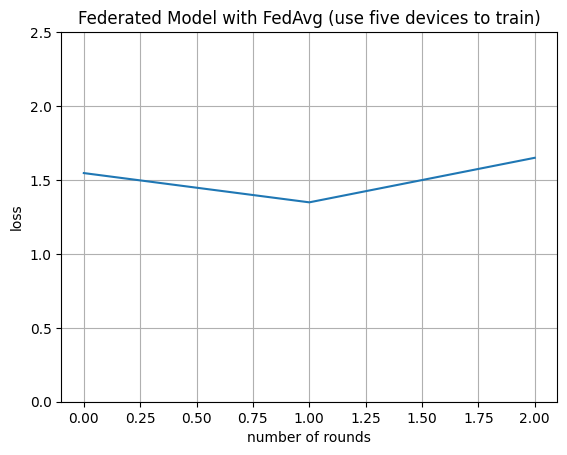

In [ ]:
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()

In [ ]:
def get_tr(model, tr_data):
    model.eval()
    mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    tr = mse.mean() + mse.std()
    return tr

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    mse = np.mean(np.power(mix_data.cpu().detach().numpy() - model(mix_data).cpu().detach().numpy(), 2), axis=1)

    prediction = []
    for i in mse:
        if i > tr:
            prediction.append(1)
        else:
            prediction.append(0)

    mix_label_list = mix_label.tolist()
    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)
    conf = [[TP, FN],[FP, TN]]
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']
    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
# load model
global_model = torch.load('global.pt')

D1: 
Acc: 99.975% 
Precision: 1.000 
Recall: 1.000 
F1score: 99.987 
TPR: 1.00000 
FPR: 0.00702

D2: 
Acc: 99.963% 
Precision: 1.000 
Recall: 1.000 
F1score: 99.982 
TPR: 1.00000 
FPR: 0.04118

D3: 
Acc: 37.631% 
Precision: 0.999 
Recall: 0.351 
F1score: 51.933 
TPR: 0.35081 
FPR: 0.00476
\D4: 
Acc: 99.651% 
Precision: 0.996 
Recall: 1.000 
F1score: 99.795 
TPR: 0.99999 
FPR: 0.02282


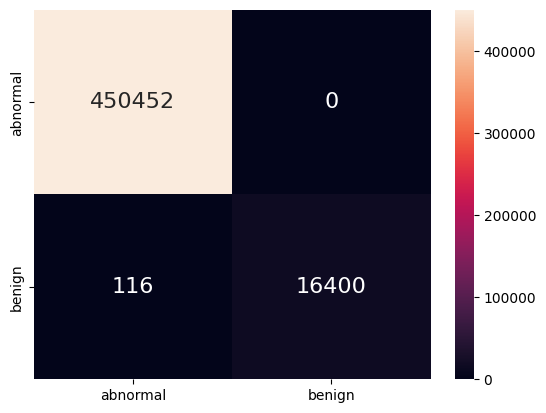

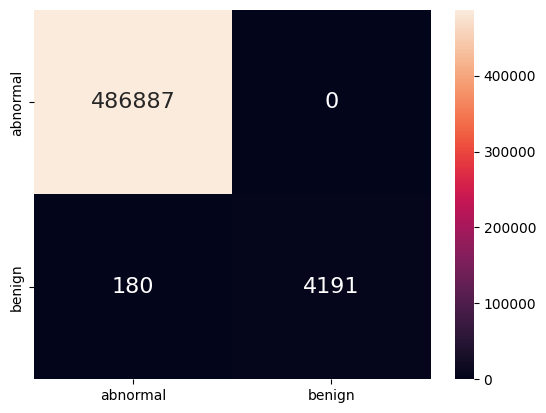

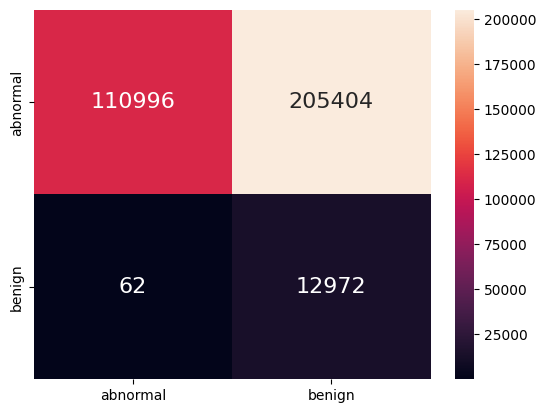

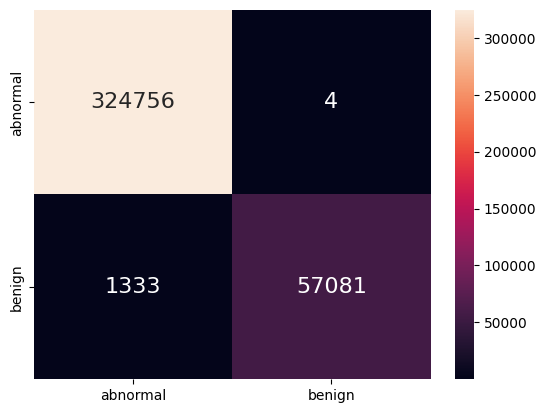

In [ ]:
# Calculate TR
tr_1 = get_tr(global_model, benign_tr_1)
tr_2 = get_tr(global_model, benign_tr_2)
tr_3 = get_tr(global_model, benign_tr_3)
tr_4 = get_tr(global_model, benign_tr_4)
tr_5 = get_tr(global_model, benign_tr_5)
tr_6 = get_tr(global_model, benign_tr_6)
tr_7 = get_tr(global_model, benign_tr_7)
tr_8 = get_tr(global_model, benign_tr_8)
tr_9 = get_tr(global_model, benign_tr_9)


# use global model & device's TR
print("D1: ")
get_mix_result(global_model, tr_1, mix_data_1, mix_label_1)
print('\nD2: ')
get_mix_result(global_model, tr_2, mix_data_2, mix_label_2)
print("\nD3: ")
get_mix_result(global_model, tr_3, mix_data_3, mix_label_3)
print("\D4: ")
get_mix_result(global_model, tr_4, mix_data_4, mix_label_4)



D5: 
Acc: 99.878% 
Precision: 0.999 
Recall: 1.000 
F1score: 99.936 
TPR: 1.00000 
FPR: 0.02698

D6: 
Acc: 99.788% 
Precision: 0.998 
Recall: 1.000 
F1score: 99.885 
TPR: 1.00000 
FPR: 0.02805

D7: 
Acc: 99.883% 
Precision: 0.999 
Recall: 1.000 
F1score: 99.939 
TPR: 0.99960 
FPR: 0.01547

D8: 
Acc: 99.843% 
Precision: 0.998 
Recall: 1.000 
F1score: 99.919 
TPR: 0.99999 
FPR: 0.04727


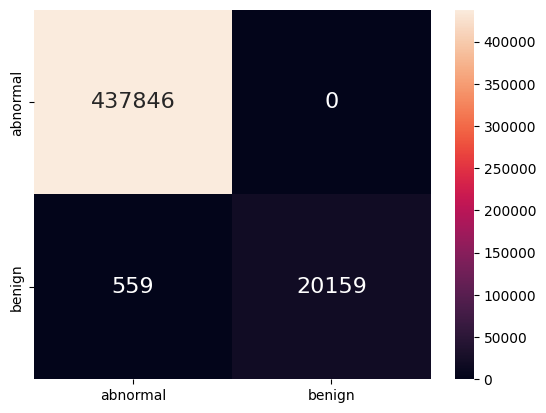

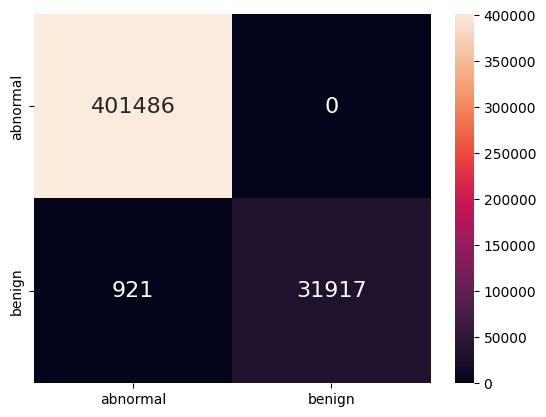

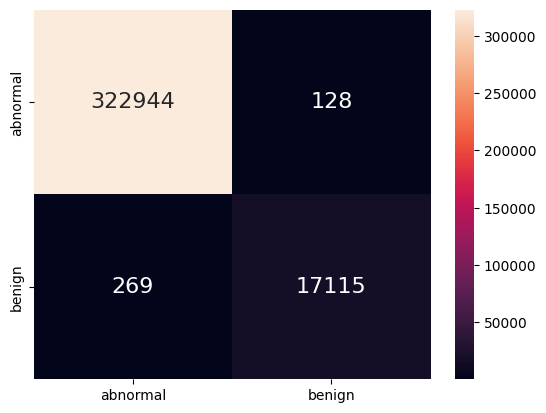

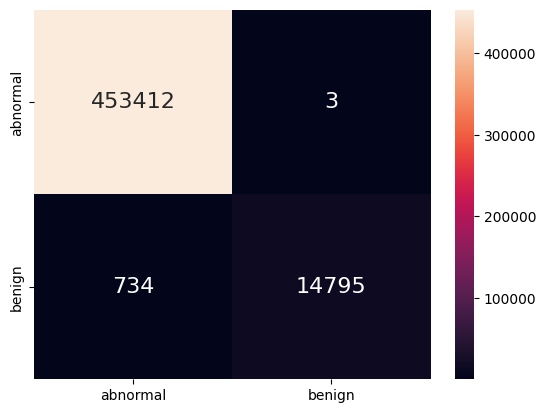

In [ ]:
print("D5: ")
get_mix_result(global_model, tr_5, mix_data_5, mix_label_5)
print('\nD6: ')
get_mix_result(global_model, tr_6, mix_data_6, mix_label_6)
print('\nD7: ')
get_mix_result(global_model, tr_7, mix_data_7, mix_label_7)
print("\nD8: ")
get_mix_result(global_model, tr_8, mix_data_8, mix_label_8)

D9:
Acc: 99.808% 
Precision: 0.998 
Recall: 1.000 
F1score: 99.900 
TPR: 1.00000 
FPR: 0.04727


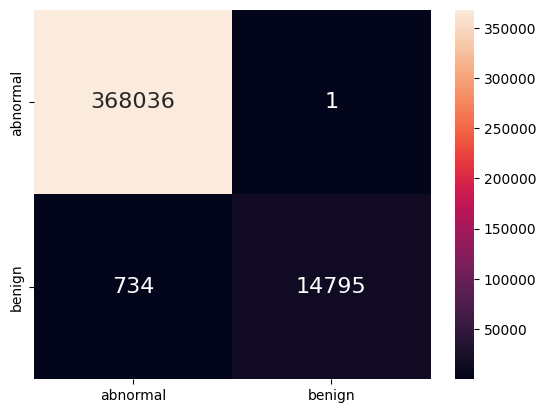

In [ ]:
print('D9:')
get_mix_result(global_model, tr_9, mix_data_9, mix_label_9)


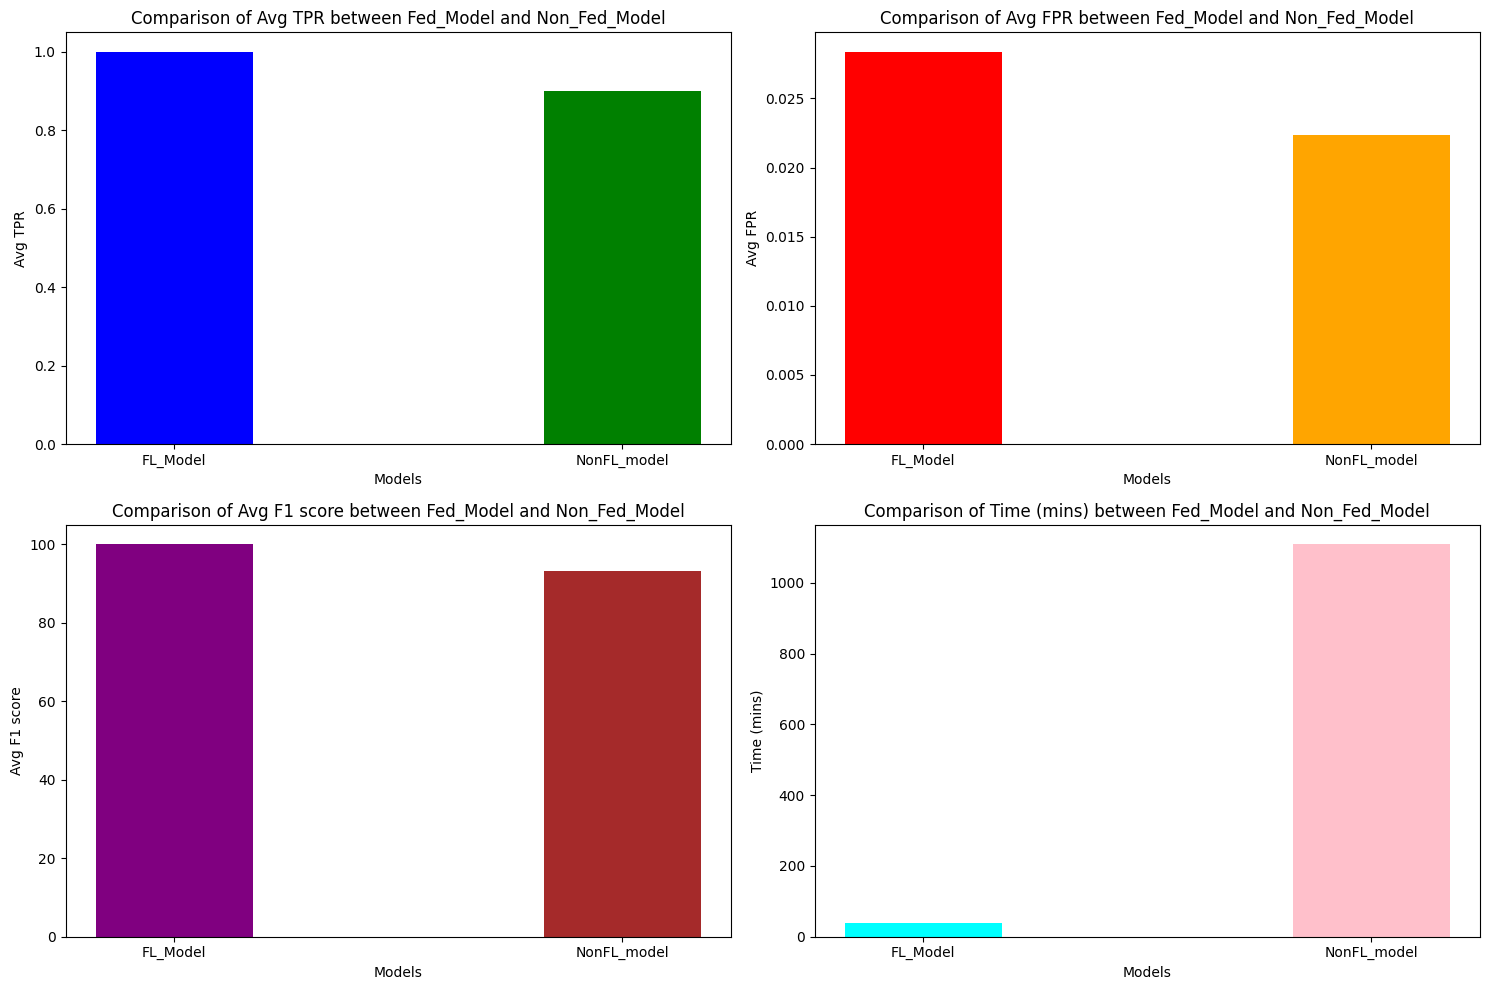

In [ ]:
import matplotlib.pyplot as plt

Fed_Model_Avg_TPR = 0.99988
Non_Fed_Model_Avg_TPR = 0.90076
Fed_Model_Avg_FPR = 0.02836
Non_Fed_Model_Avg_FPR = 0.02232
Fed_Model_Avg_F1_Score = 99.966
Non_Fed_Model_Avg_F1_Score = 93.095
Fed_Model_Time = 38.6
Non_Fed_Model_Time = 1109

# Set up positions for side-by-side bars
bar_width = 0.35
index = range(2)

# Create separate bar charts for each property
plt.figure(figsize=(15, 10))

# Bar for Avg TPR
plt.subplot(2, 2, 1)
plt.bar(index, [Fed_Model_Avg_TPR, Non_Fed_Model_Avg_TPR], bar_width, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Avg TPR')
plt.title('Comparison of Avg TPR between Fed_Model and Non_Fed_Model')
plt.xticks(index, ['FL_Model', 'NonFL_model'])

# Bar for Avg FPR
plt.subplot(2, 2, 2)
plt.bar(index, [Fed_Model_Avg_FPR, Non_Fed_Model_Avg_FPR], bar_width, color=['red', 'orange'])
plt.xlabel('Models')
plt.ylabel('Avg FPR')
plt.title('Comparison of Avg FPR between Fed_Model and Non_Fed_Model')
plt.xticks(index, ['FL_Model', 'NonFL_model'])

# Bar for Avg F1 score
plt.subplot(2, 2, 3)
plt.bar(index, [Fed_Model_Avg_F1_Score, Non_Fed_Model_Avg_F1_Score], bar_width, color=['purple', 'brown'])
plt.xlabel('Models')
plt.ylabel('Avg F1 score')
plt.title('Comparison of Avg F1 score between Fed_Model and Non_Fed_Model')
plt.xticks(index, ['FL_Model', 'NonFL_model'])

# Bar for Time (mins)
plt.subplot(2, 2, 4)
plt.bar(index, [Fed_Model_Time, Non_Fed_Model_Time], bar_width, color=['cyan', 'pink'])
plt.xlabel('Models')
plt.ylabel('Time (mins)')
plt.title('Comparison of Time (mins) between Fed_Model and Non_Fed_Model')
plt.xticks(index, ['FL_Model', 'NonFL_model'])

# Adjust layout
plt.tight_layout()

# Show the graphs
plt.show()
